## Recurrent event: Exploratory Data Analysis

- This notebook dedicated to understanding the recurrent event process
- End-of-Day (EOD) EMA: compute first day of EOD
- Self-report: compute first day of self-reported smoking since quit date and 

In [70]:
# Import packages and set directory
import pandas as pd
import numpy as np
import datetime as datetime
import os
print(os.getcwd())
dir = "../final-data"

C:\Users\wdem\Documents\GitHub\sense2stop-lvm\final-data


'C:\\Users\\wdem\\Documents\\GitHub\\sense2stop-lvm\\final-data'

In [41]:
# Response windows for end-of-day EMA
keys = ['8to9', '9to10', '10to11', '11to12',
        '12to13','13to14','14to15','15to16',
        '16to17','17to18','18to19','19to20']


In [42]:
# read EOD data and participant entry/exit dates
eod_ema = pd.read_csv(os.path.join(os.path.realpath(dir), 'eod-ema-final.csv'))
participant_dates = pd.read_csv(os.path.join(os.path.realpath(dir),'participant-dates-v3.csv'))

In [43]:
# Construct user-days and record how many cigarettes
# are reported in the EOD EMA
eod_dates = []
for irow in range(0,eod_ema.shape[0]):
    row = eod_ema.iloc[irow]
    quit_iloc = np.where(participant_dates['participant'] == row['participant_id'])
    quit_row = participant_dates.iloc[quit_iloc[0][0]]
    quit_time = datetime.datetime.strptime(quit_row['quit_date'], '%m/%d/%y')
    if row['status'] == "MISSED":
        continue
    try:
        time = datetime.datetime.strptime(row['date'], '%m/%d/%Y %H:%M')
    except:
        time = datetime.datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S')
    #print row['participant_id'], time
    #print quit_row['participant'], quit_time
    temp_diff = time - quit_time
    if time.hour  == 0 or time.hour == 1:
        date = np.array([row['participant_id'], temp_diff.days-1])
        date = np.append(date, np.sum(np.array(row[keys])))
    else:
        date = np.array([row['participant_id'], temp_diff.days])
        date = np.append(date, np.sum(np.array(row[keys])))
    #print date
    eod_dates.append(date)
    
eod_dates = np.asarray(eod_dates)
eod_dates

array([[201.,  -3.,   2.],
       [201.,  -2.,   9.],
       [203.,   6.,   0.],
       ...,
       [269.,   8.,   0.],
       [269.,   9.,   0.],
       [269.,  10.,   0.]])

In [44]:
## Each day get the mean and standard deviation
## in the number of reported cigarettes using end-of-day EMA
for day in range(-3, 11):
    print(day, np.round(np.nanmean(eod_dates[eod_dates[:,1] == day,2]),3), np.round(np.nanstd(eod_dates[eod_dates[:,1] == day,2]),3))

-3 4.444 2.948
-2 4.812 3.193
-1 4.227 2.867
0 1.7 2.015
1 1.237 1.286
2 1.735 2.429
3 1.324 2.529
4 1.176 2.022
5 1.629 2.294
6 1.424 2.118
7 1.839 2.554
8 1.735 1.975
9 1.676 2.665
10 2.0 3.215


In [65]:
eod_survival = []
for id in np.unique(eod_dates[:,0]):
    subset = eod_dates[eod_dates[:,0] == id,:]
    if any(subset[:,1] > 0):
        subset = subset[subset[:,1] > 0,:]
        nonzero_iloc = np.where(subset[:,2] > 0)[0]
        zero_iloc = np.where(subset[:,2] == 0)[0]
        if len(nonzero_iloc) == 0:
            if len(zero_iloc) != 0:
                temp = np.append(subset[np.max(zero_iloc),0:2], 0)
        else:
            temp = np.append(subset[np.max(nonzero_iloc), 0:2], 1)
        eod_survival.append(temp)

eod_survival = np.asarray(eod_survival)

C:\Users\wdem\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [71]:
# Read data for self-report
selfreport = pd.read_csv(os.path.join(os.path.realpath(dir), 'self-report-smoking-final.csv'))

In [72]:
'''
Extract all smoking events and label with correct user-day
'''

sr_dates = []
for irow in range(0,selfreport.shape[0]):
    row = selfreport.iloc[irow]
    quit_iloc = np.where(participant_dates['participant'] == row['participant_id'])
    quit_row = participant_dates.iloc[quit_iloc[0][0]]
    quit_time = datetime.datetime.strptime(quit_row['quit_date'], '%m/%d/%y')
    try:
        time = datetime.datetime.strptime(row['date'], '%m/%d/%y %H:%M')
    except:
        time = datetime.datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S')
    temp_diff = time - quit_time
    if time.hour  == 0 or time.hour == 1:
        date = np.array([row['participant_id'], temp_diff.days-1])
    else:
        date = np.array([row['participant_id'], temp_diff.days])
    sr_dates.append(date)
    
sr_dates = np.asarray(sr_dates)

array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
      dtype=int64)

In [73]:
'''
Aggregate smoking events for each user-day
'''

sr_pd = pd.DataFrame(sr_dates)
sr_pd.columns = ['user', 'day']
sr_userdays = sr_pd.groupby(['user','day']).size()

sr_userdays.groupby('day').mean()

day
-4     2.500000
-3     4.380952
-2     7.210526
-1     6.056604
 0     3.000000
 1     2.476190
 2     3.578947
 3     4.000000
 4     5.153846
 5     5.307692
 6     5.833333
 7     5.571429
 8     6.076923
 9     3.800000
 10    5.642857
 11    2.000000
dtype: float64

In [85]:
'''
For each user, find the first user-day on which 
they self-reported smoking
''' 

sr_survival = []
for id in np.unique(sr_dates[:,0]):
    subset = sr_dates[sr_dates[:,0] == id,:]
    if any(subset[:,1] > 0):
        subset = subset[subset[:,1] > 0,:]
        temp = [id, np.max(subset[:,1])]
        sr_survival.append(temp)

sr_survival = np.asarray(sr_survival)

array([[202,  10],
       [207,   1],
       [208,   7],
       [211,   2],
       [212,   8],
       [214,   2],
       [215,  10],
       [216,  10],
       [217,   3],
       [218,   1],
       [219,  10],
       [224,   9],
       [226,  10],
       [227,  11],
       [228,  11],
       [229,   4],
       [231,   2],
       [233,   6],
       [238,  10],
       [240,  11],
       [241,   1],
       [243,   5],
       [247,   1],
       [249,   1],
       [252,   9],
       [253,  11],
       [254,   4],
       [255,  10],
       [256,   5],
       [259,   8],
       [261,  10],
       [262,  10],
       [263,   2],
       [264,   1],
       [265,   2],
       [266,   1],
       [267,  10]], dtype=int64)

In [78]:
# Read data for random EMA
random_ema = pd.read_csv(os.path.join(os.path.realpath(dir),'random-ema-final.csv'))

In [86]:
'''
Extract all smoking events from random EMA and label with correct user-day
'''

random_dates = []
for irow in range(0,random_ema.shape[0]):
    row = random_ema.iloc[irow]
    quit_iloc = np.where(participant_dates['participant'] == row['participant_id'])
    quit_row = participant_dates.iloc[quit_iloc[0][0]]
    quit_time = datetime.datetime.strptime(quit_row['quit_date'], '%m/%d/%y')
    if row['status'] == "MISSED":
        continue
    try:
        time = datetime.datetime.strptime(row['date'], '%m/%d/%y %H:%M')
    except:
        time = datetime.datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S')
    #print row['participant_id'], time
    #print quit_row['participant'], quit_time
    temp_diff = time - quit_time
    if time.hour  == 0 or time.hour == 1:
        date = np.array([row['participant_id'], temp_diff.days-1])
        if row['smoke'] == 'Yes':
            date = np.append(date, [1])
            random_dates.append(date)
        if row['smoke'] == 'No':
            date = np.append(date, [0])
            random_dates.append(date)
    else:
        date = np.array([row['participant_id'], temp_diff.days])
        if row['smoke'] == 'Yes':
            date = np.append(date, 1)
            random_dates.append(date)
        if row['smoke'] == 'No':
            date = np.append(date, 0)
            random_dates.append(date)

random_dates = np.asarray(random_dates)

array([[201,  -3,   0],
       [201,  -3,   0],
       [201,  -2,   0],
       ...,
       [269,  10,   0],
       [269,  10,   0],
       [270,  -3,   0]], dtype=int64)

In [87]:
'''
Aggregate smoking events for each user-day
within the random EMA
'''

random_pd = pd.DataFrame(random_dates)
random_pd.columns = ['user', 'day', 'smoke']
random_pd_userdays = random_pd.groupby(['user','day'])['smoke'].sum().reset_index()

In [90]:
random_survival = []
for id in np.unique(random_dates[:,0]):
    subset = random_dates[random_dates[:,0] == id,:]
    if any(subset[:,1] > 0):
        subset = subset[subset[:,1] > 0,:]
        nonzero_iloc = np.where(subset[:,2] == 1)[0]
        zero_iloc = np.where(subset[:,2] == 0)[0]
        if len(nonzero_iloc) == 0:
            if len(zero_iloc) != 0:
                temp = np.append(subset[np.max(zero_iloc),0:2], 0)
        else:
            temp = np.append(subset[np.max(nonzero_iloc), 0:2], 1)
        random_survival.append(temp)

random_survival = np.asarray(random_survival)

In [174]:
all_ema_survival = np.array([])
sr_random_survival = np.array([])

for id in np.unique(np.concatenate([random_survival[:,0], sr_survival[:,0], eod_survival[:,0]])):
    temp = np.array([id])
    random_subset = random_survival[random_survival[:,0] == id,:]
    if not len(random_subset) == 0:
        temp = np.append(temp, random_subset[0][1:3])
    else:
        temp = np.append(temp, [-1,-1]) 
    sr_subset = sr_survival[sr_survival[:,0] == id,:]
    if not len(sr_subset) == 0:
        sr_day = sr_subset[0][1]
        if temp[1] > sr_day or temp[1] == -1:
            temp[1:3] = [sr_day,1]
    temp2 = temp
    sr_random_survival = np.append(sr_random_survival, temp2)
    eod_subset = eod_survival[eod_survival[:,0] == id, :]
    if not len(eod_subset) == 0:
        if eod_subset[0][1] < temp[1] and eod_subset[0][2] == 1:
            temp[1:3] = eod_subset[0][1:3]
        elif eod_subset[0][1] > temp[1] and eod_subset[0][2] == 0 and temp[2] == 0:
            temp[1:3] = eod_subset[0][1:3]
    all_ema_survival = np.append(all_ema_survival, temp)

sr_random_survival = np.reshape(sr_random_survival, (-1,3))
all_ema_survival = np.reshape(all_ema_survival, (-1,3))

np.concatenate((sr_random_survival, all_ema_survival), )

In [160]:
def km_estimation(day_range, survival_data):
    km_list = [1]
    var_list = [0]
    for day in day_range:
        n_day = np.sum(survival_data[:,1] >= day, dtype='f')
        subset = survival_data[survival_data[:,1] == day,:]
        subset = subset[subset[:,2] == 1]
        d_day = subset.shape[0]
        km_list.append(1-d_day/n_day)
        var_list.append(d_day/(n_day * (n_day - d_day)))

    km_est = np.cumprod(km_list)

    var_est = np.multiply(np.power(km_est,2),np.cumsum(var_list))

    km_stderr = np.sqrt(var_est)

    upper_km_est = km_est + 1.96*km_stderr
    lower_km_est = km_est - 1.96*km_stderr
    return(lower_km_est, km_est, upper_km_est)

In [165]:
lower_km_est, km_est, upper_km_est = km_estimation(day_range, all_ema_survival)

eod_lower_km_est, eod_km_est, eod_upper_km_est = km_estimation(day_range, eod_survival)

sr_random_lower_km_est, sr_random_km_est, sr_random_upper_km_est = km_estimation(day_range, sr_random_survival)

np.concatenate((all_ema_survival, sr_random_survival), axis = 1)

array([[202.,   7.,   1., 202.,   7.,   1.],
       [203.,  13.,   0., 203.,  13.,   0.],
       [205.,   8.,   1., 205.,   8.,   1.],
       [206.,   9.,   0., 206.,   9.,   0.],
       [207.,   1.,   1., 207.,   1.,   1.],
       [208.,   3.,   1., 208.,   3.,   1.],
       [211.,   2.,   1., 211.,   2.,   1.],
       [212.,   6.,   1., 212.,   6.,   1.],
       [213.,   1.,   0., 213.,   1.,   0.],
       [214.,   2.,   1., 214.,   2.,   1.],
       [215.,  10.,   1., 215.,  10.,   1.],
       [216.,  10.,   1., 216.,  10.,   1.],
       [217.,   3.,   1., 217.,   3.,   1.],
       [218.,   1.,   1., 218.,   1.,   1.],
       [219.,  10.,   1., 219.,  10.,   1.],
       [222.,   1.,   1., 222.,   1.,   1.],
       [223.,  11.,   0., 223.,  11.,   0.],
       [224.,   9.,   1., 224.,   9.,   1.],
       [225.,   9.,   1., 225.,   9.,   1.],
       [226.,   8.,   1., 226.,   8.,   1.],
       [227.,  10.,   1., 227.,  10.,   1.],
       [228.,   8.,   1., 228.,   8.,   1.],
       [22

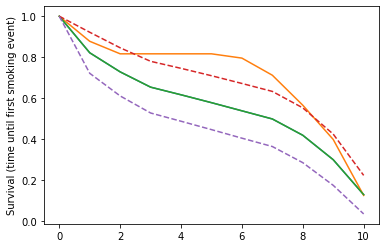

In [162]:
import matplotlib.pyplot as plt
plt.plot(km_est)
plt.plot(eod_km_est)
plt.plot(sr_random_km_est)
plt.plot(upper_km_est,linestyle='dashed')
plt.plot(lower_km_est,linestyle='dashed')
plt.ylabel('Survival (time until first smoking event)')
plt.show()

